Step 0: Ensemble mean = -0.011797607074414787, Ensemble variance = 0.041165035990486584, Kalman gain = 0.9786045588977139
Step 1: Ensemble mean = 0.11871074423606304, Ensemble variance = 0.0010291294974089304, Kalman gain = 0.5334683331477664
Step 2: Ensemble mean = 0.09967576003802937, Ensemble variance = 0.0006696205759807673, Kalman gain = 0.4266130211515348
Step 3: Ensemble mean = 0.0960636443785855, Ensemble variance = 0.0003167907513037271, Kalman gain = 0.26034940762353964
Step 4: Ensemble mean = 0.10458360842291622, Ensemble variance = 0.0002469668158464821, Kalman gain = 0.2153216749032239
Step 5: Ensemble mean = 0.1071194329954196, Ensemble variance = 0.00020789452092437116, Kalman gain = 0.18764829773768937
Step 6: Ensemble mean = 0.122038924399994, Ensemble variance = 0.00015205464703728377, Kalman gain = 0.14453113007531357
Step 7: Ensemble mean = 0.13501360386826225, Ensemble variance = 0.0001464042941850845, Kalman gain = 0.13991178648507058
Step 8: Ensemble mean = 0.149

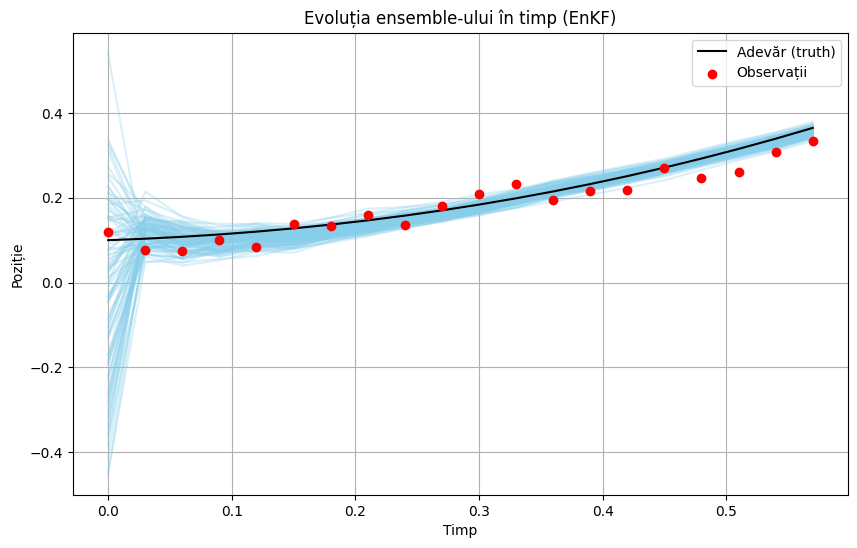

Media la pasul final: 0.35560999904424484
Deviația standard la pasul final: 0.008924448800166995


In [13]:
import numpy as np
import math 
import matplotlib.pyplot as plt

def f(x,t):
    return math.cos(t) * x + math.sin(t)


#functia euler imbunatatita
def heun_step(x, t, h):
    k1 = f(x, t)
    # k2 = f(x + h * k1, t + h)
    k2 = f(t+h, x + h * k1)
    return x + (h / 2) * (k1 + k2)

#returneaza intervalele de timp la care s-au facut 
def integrate_heun(x0, t0, t_end, h):
    #times - intervalele de timp 
    times = np.arange(t0, t_end + h, h)
    x = np.zeros_like(times)
    x[0] = x0
    for i in range(1, len(times)):
        x[i] = heun_step(x[i - 1], times[i - 1], h)
    return times, x

#x0 - valoarea initiala
#h - intervalul de esantionare
#k - nr de observatii
#noise_std - deviatia standard a observatiilor
#returneaza observatiile si adevarul
def generate_observations(x0, h, k, noise_std):
    _, truth = integrate_heun(x0, 0, h * (k-1), h)
    obs = truth + np.random.normal(0, noise_std, size=k)
    return obs, truth



def enkf(x0_mean, x0_std, obs, h, R, ensemble_size):
    k = len(obs)
    ensemble = np.random.normal(x0_mean, x0_std, size=ensemble_size)
    all_ensembles = []

    # itterate through k obs steps
    for step in range(k):
        
        #for each itteration we apply the heun step
        for i in range(ensemble_size):
            ## prediction step ##
            ensemble[i] = heun_step(ensemble[i], step * h, h)

        # store the ensebmle values after the prediction step and before the update step
        all_ensembles.append(ensemble.copy())

        ## update step based on the observations ##
        
        x_mean = np.mean(ensemble)

        #calculate the variance of the model(std deviation squared)
        P = np.var(ensemble)

        # calculate the Kalman gain
        # number bewtween 0 and 1 that represents how much I trust the observation in compaison to the model
        K = P / (P + R)
        print(f"Step {step}: Ensemble mean = {x_mean}, Ensemble variance = {P}, Kalman gain = {K}")
        obs_noise = np.random.normal(0, np.sqrt(R), size=ensemble_size)
        ensemble = ensemble + K * (obs[step] + obs_noise - ensemble)

    return np.array(all_ensembles)



# Configurare parametri
x0_true = 0.1
x0_std = 0.2
h = 0.03
k = 20
obs_noise_std = 0.03
R = obs_noise_std**2
ensemble_size = 100

# Simulări
obs, truth = generate_observations(x0_true, h, k, obs_noise_std)
all_ensembles = enkf(0, x0_std, obs, h, R, ensemble_size)

# Plot
plt.figure(figsize=(10, 6))
for i in range(ensemble_size):
    plt.plot(np.arange(k) * h, all_ensembles[:, i], color='skyblue', alpha=0.3)
plt.plot(np.arange(k) * h, truth, color='black', label='Adevăr (truth)')
plt.scatter(np.arange(k) * h, obs, color='red', label='Observații', zorder=10)
plt.title("Evoluția ensemble-ului în timp (EnKF)")
plt.xlabel("Timp")
plt.ylabel("Poziție")
plt.legend()
plt.grid()
plt.show()

# Medie și dev. standard la pas final
final_ensemble = all_ensembles[-1]
print("Media la pasul final:", np.mean(final_ensemble))
print("Deviația standard la pasul final:", np.std(final_ensemble))


Step 1: Ensemble mean = 0.03314919373559643, Ensemble variance = 0.03296182390855807, Kalman gain = 0.9734213962475737
Step 7: Ensemble mean = 0.19256141504229898, Ensemble variance = 0.0012017232390409186, Kalman gain = 0.5717799645158332
Step 17: Ensemble mean = 0.3709728500335692, Ensemble variance = 0.0006703682565321154, Kalman gain = 0.42688602099771605
Step 26: Ensemble mean = 0.6280418083677612, Ensemble variance = 0.0005434668401596908, Kalman gain = 0.3765010910119467
Step 37: Ensemble mean = 1.0749820317042358, Ensemble variance = 0.0004190988573686683, Kalman gain = 0.31771603396328046
Step 47: Ensemble mean = 1.4917790775120414, Ensemble variance = 0.0001983439800009125, Kalman gain = 0.18058457424307794
Step 56: Ensemble mean = 1.7548094007768384, Ensemble variance = 0.00010334151158436192, Kalman gain = 0.10299734476367559
Step 67: Ensemble mean = 1.910855931351045, Ensemble variance = 4.464125635956359e-05, Kalman gain = 0.047257364696944346
Step 77: Ensemble mean = 1.9

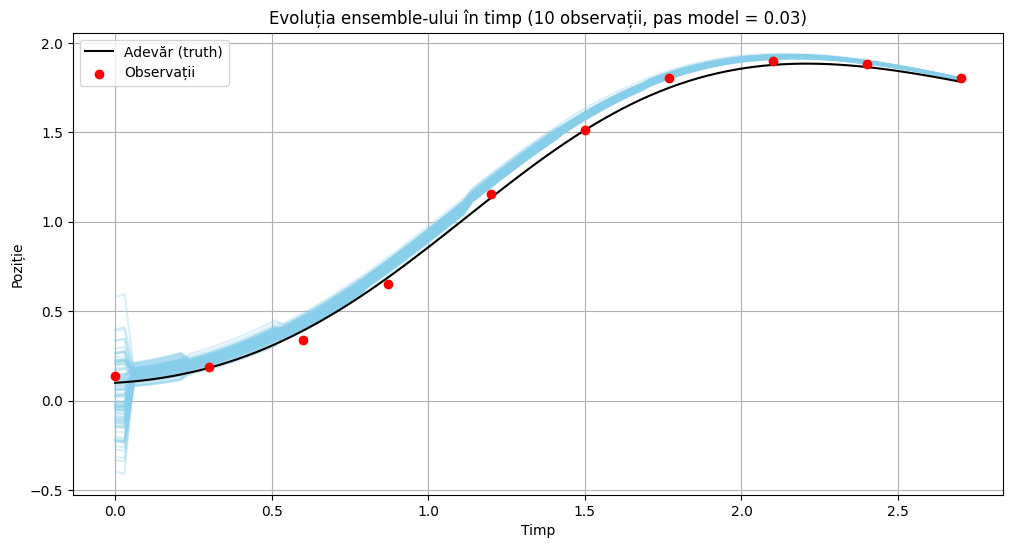

Media la pasul final: 1.7992768395735133
Deviația standard la pasul final: 0.0021235275850068984


In [31]:
import numpy as np
import matplotlib.pyplot as plt

def f(x,t):
    return math.cos(t) * x + math.sin(t)

def heun_step(x, t, h):
    k1 = f(x, t)
    k2 = f(t+h, x + h * k1)
    return x + (h / 2) * (k1 + k2)

def integrate_heun(x0, t0, t_end, h):
    times = np.arange(t0, t_end + h, h)
    x = np.zeros_like(times)
    x[0] = x0
    for i in range(1, len(times)):
        x[i] = heun_step(x[i-1], times[i-1], h)
    return times, x

def generate_observations(x0, h_obs, h_model, num_obs, noise_std):
    t_end = h_obs * (num_obs - 1)
    times_full, truth = integrate_heun(x0, 0, t_end, h_model)
    obs_indices = [int(i * h_obs / h_model) for i in range(num_obs)]
    obs_values = truth[obs_indices] + np.random.normal(0, noise_std, size=num_obs)
    obs_times = times_full[obs_indices]
    return obs_times, obs_values, truth, times_full

def enkf_variable_update(x0_mean, x0_std, obs_times, obs_values, h_model, R, ensemble_size, t_total):
    n_steps = int(t_total / h_model) + 1
    times = np.arange(0, t_total + h_model, h_model)
    ensemble = np.random.normal(x0_mean, x0_std, size=ensemble_size)
    all_ensembles = np.zeros((n_steps, ensemble_size))
    all_ensembles[0] = ensemble

    obs_pointer = 0
    for step in range(1, n_steps):
        t = times[step-1]

        for i in range(ensemble_size):
            ensemble[i] = heun_step(ensemble[i], t, h_model)
        all_ensembles[step] = ensemble

        if obs_pointer < len(obs_times) and np.isclose(times[step], obs_times[obs_pointer], atol=1e-1):
            x_mean = np.mean(ensemble)
            P = np.var(ensemble)
            K = P / (P + R)
            print(f"Step {step}: Ensemble mean = {x_mean}, Ensemble variance = {P}, Kalman gain = {K}")
            obs_noise = np.random.normal(0, np.sqrt(R), size=ensemble_size)
            ensemble = ensemble + K * (obs_values[obs_pointer] + obs_noise - ensemble)
            obs_pointer += 1

    print(obs_pointer)
    return times, all_ensembles

x0_true = 0.1
x0_std = 0.2
h_model = 0.03
h_obs = 0.3
num_obs = 10
obs_noise_std = 0.03
R = obs_noise_std ** 2
ensemble_size = 100

obs_times, obs_values, truth, times_full = generate_observations(x0_true, h_obs, h_model, num_obs, obs_noise_std)

times, all_ensembles = enkf_variable_update(0, x0_std, obs_times, obs_values, h_model, R, ensemble_size, t_total=times_full[-1])

plt.figure(figsize=(12, 6))
for i in range(ensemble_size):
    plt.plot(times, all_ensembles[:, i], color='skyblue', alpha=0.3)
plt.plot(times_full, truth[:len(times_full)], color='black', label='Adevăr (truth)')
plt.scatter(obs_times, obs_values, color='red', label='Observații', zorder=10)
plt.title("Evoluția ensemble-ului în timp (10 observații, pas model = 0.03)")
plt.xlabel("Timp")
plt.ylabel("Poziție")
plt.legend()
plt.grid()
plt.show()

final_ensemble = all_ensembles[-1]
print("Media la pasul final:", np.mean(final_ensemble))
print("Deviația standard la pasul final:", np.std(final_ensemble))
